In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.global_variables import GlobalVariables
from src.data_loader import market_data_loader, cashflows_loader, get_spot_prices, get_latest_quote
from src.fx_simulator import estimate_gbm_params, simulate_gbm_paths
from src.metrics.performance import irr, moic, npv, terminal_value
from src.metrics.risk import risk_summary_for_metric, prob_below
from src.hedges.forwards import forward_hedge_cashflows_usd
from src.hedges.options import put_option_hedge_cashflows_usd

In [2]:
# Set Up
global_variables = GlobalVariables(
    market_data_path='QuantResearch-CaseStudy-MarketData-25.xlsx',
    analysis_start_date=pd.Timestamp('2025-08-01'),
    n_paths=250000
)

In [ ]:
# Loading Market Data
market_data = market_data_loader(
    path=global_variables.market_data_path
)
spots = get_spot_prices(
    market_data=market_data,
    price='mid'
)
s0 = get_latest_quote(
    market_data=market_data,
    price='mid',
    analysis_start_date=global_variables.analysis_start_date,
    ticker='spot'
).item()

# Loading Cashflow Data
cashflows = cashflows_loader()

In [4]:
# Calibrating FX Model
mu_hat, sigma_hat = estimate_gbm_params(
    spots=spots,
    steps_per_year=global_variables.steps_per_year,
    use_zero_mu=global_variables.use_zero_mu
)

In [5]:
# Simulate FX Spot Rates
dates, spot_paths = simulate_gbm_paths(
    s0=s0,
    mu=mu_hat,
    sigma=sigma_hat,
    start=global_variables.analysis_start_date,
    end=cashflows.index.max(),
    n_paths= global_variables.n_paths,
    steps_per_year=global_variables.steps_per_year,
)

In [6]:
colors = {'c1': '#659999',
          'c2': '#f4791f',
          'c3': '#f12711'}
          # https://uigradients.com/#Metapolis

## Unhedged

In [7]:
# Cashflows and their Dates 
cashflow_dates = np.asarray(cashflows.index)
cashflow_dates_idx = dates.get_indexer(cashflow_dates, method='pad')
cashflow_eur = np.asarray(cashflows['cf_eur'])

# Check Cashflow Dates Within Path Simulation Dates
if (cashflow_dates_idx < 0).any():
    missing = cashflow_dates[cashflow_dates_idx < 0]
    raise ValueError(f'Cashflow dates before simulation begins: {missing}')

# Evaluating Unhedged Performance
hedge_cashflow_usd_unhedged = np.zeros((global_variables.n_paths, cashflows.size))

# Unhedged Performance Metrics
irr_unhedged = np.empty(global_variables.n_paths, dtype=float)
moic_unhedged = np.empty(global_variables.n_paths, dtype=float)
npv_unhedged = np.empty(global_variables.n_paths, dtype=float)
terminal_unhedged = np.empty(global_variables.n_paths, dtype=float)

# Iterating each Simulated Spot Path
for p in range(global_variables.n_paths):
    spots_on_cashflow_dates = spot_paths[p, cashflow_dates_idx]
    cashflow_usd = cashflow_eur * spots_on_cashflow_dates + hedge_cashflow_usd_unhedged[p]

    # Charging Premium
    if global_variables.premium != 0.0:
        cashflow_usd = cashflow_usd.copy()
        cashflow_usd[0] -= global_variables.premium

    irr_unhedged[p] = irr(
        cashflow_dates=cashflow_dates,
        cashflows=cashflow_usd,
        start_date=cashflow_dates[0],
    )
    moic_unhedged[p] = moic(
        cashflows=cashflow_usd
    )
    npv_unhedged[p] = npv(
        cashflow_dates=cashflow_dates,
        cashflows=cashflow_usd,
        r = global_variables.discount_rate,
        start_date=global_variables.analysis_start_date
    )
    terminal_unhedged[p] = terminal_value(
        cashflows=cashflow_usd
    )

performance_unhedged = {
    'strategy': 'unhedged',
    'irr': irr_unhedged,
    'moic': moic_unhedged,
    'npv': npv_unhedged,
    'terminal': terminal_unhedged,
    'premium': global_variables.premium
}

# No Root was found
nan_rate_irr_unhedged = np.isnan(irr_unhedged).mean()
print('IRR NaN rate :', nan_rate_irr_unhedged)

IRR NaN rate : 0.0


In [8]:
# Unhedged Risk
risk_npv_unhedged = risk_summary_for_metric(performance_unhedged['npv'], alpha=global_variables.alpha, loss='npv_shortfall')
risk_irr_unhedged = risk_summary_for_metric(performance_unhedged['irr'], alpha=global_variables.alpha, loss='irr_shortfall')
risk_moic_unhedged = risk_summary_for_metric(performance_unhedged['moic'], alpha=global_variables.alpha, loss='moic_shortfall')

p_npv_neg = prob_below(performance_unhedged['npv'], 0.0)
p_irr_neg = prob_below(performance_unhedged['irr'], 0.0)
p_moic_lt1 = prob_below(performance_unhedged['moic'], 1.0)

/var/folders/vq/vfvbw4712s38pzgg57fngcsm0000gn/T/ipykernel_8566/4076766033.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1 = cashflows.index[idx], cumsum[idx]
/var/folders/vq/vfvbw4712s38pzgg57fngcsm0000gn/T/ipykernel_8566/4076766033.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2, y2 = cashflows.index[idx+1], cumsum[idx+1]


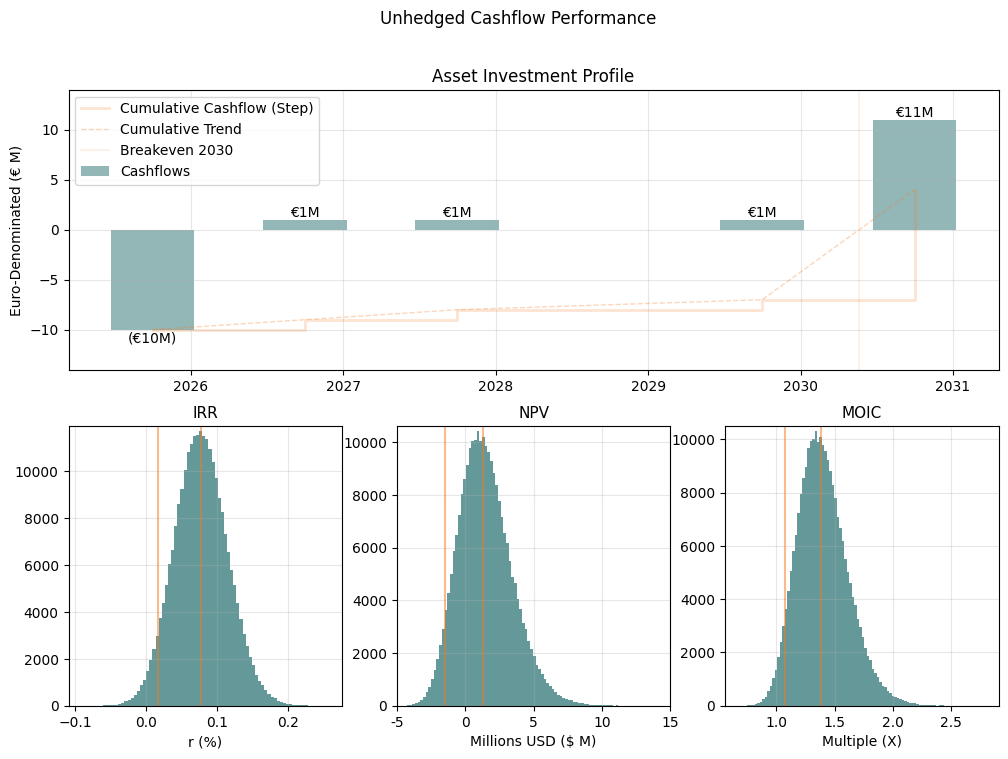

In [9]:
# Unhedged Results
fig = plt.figure(figsize = (12, 8))
plt.suptitle('Unhedged Cashflow Performance')

# Fig 1) Investment Profile
ax = plt.subplot2grid((2, 3), (0, 0), colspan=3)

# Cashflows
bars = ax.bar(height=cashflows.cf_eur / 1e6, x=cashflows.index, width=200,
              color=colors['c1'], alpha=0.7, label='Cashflows')

# Annotations
for bar, val in zip(bars, cashflows.cf_eur):
    millions = val / 1e6
    if val >= 0:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02, 
                f'€{millions:.0f}M', ha='center', va='bottom')
    else:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() - 0.2, 
                f'(€{-millions:.0f}M)', ha='center', va='top')

cumsum = np.cumsum(cashflows.cf_eur / 1e6)
ax.step(cashflows.index, cumsum, where='post', color=colors['c2'], linewidth=2, 
        label='Cumulative Cashflow (Step)', alpha=0.2)

ax.plot(cashflows.index, cumsum, color=colors['c2'], linewidth=1, ls='--', 
        label='Cumulative Trend', alpha=0.3)

# Breakeven
cross_idx = np.where(np.diff(np.sign(cumsum)))[0]
if len(cross_idx) > 0:
    idx = cross_idx[0]
    x1, y1 = cashflows.index[idx], cumsum[idx]
    x2, y2 = cashflows.index[idx+1], cumsum[idx+1]
    be_x = x1 + (x2 - x1) * abs(y1) / (abs(y1) + abs(y2))
    ax.axvline(be_x, ls='-', alpha=0.1, color=colors['c2'],
               label=f'Breakeven {pd.Timestamp(be_x).strftime("%Y")}')

# Layout
ax.grid(True, alpha=0.3)
ax.set_ylim([-14, 14])
ax.legend(loc='upper left')
ax.set_title('Asset Investment Profile')
ax.set_ylabel('Euro-Denominated (€ M)')

# IRR - Internal Rate of Return
ax = plt.subplot2grid((2, 3), (1, 0))

y, x, _ = ax.hist(
    x=performance_unhedged['irr'],
    bins=80,
    color=colors['c1']
)

# IRR VaR 95%
ax.vlines(
    x=risk_irr_unhedged['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Median
ax.vlines(
    x=risk_irr_unhedged['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Layout
ax.set_title('IRR', fontsize=11)
ax.set_xlabel('r (%)')
ax.set_ylim([0, y.max() * 1.02])
ax.grid(True, alpha=0.3)

# NPV - Net PResent Value
ax = plt.subplot2grid((2, 3), (1, 1))

y, x, _ = ax.hist(
    x=performance_unhedged['npv'],
    bins=100,
    color=colors['c1']
)

# NPV VaR 95%
ax.vlines(
    x=risk_npv_unhedged['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# NPV Median
ax.vlines(
    x=risk_npv_unhedged['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# NPV Layout
ax.set_title('NPV', fontsize=11)
ax.set_xlabel('Millions USD ($ M)')

ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 4200])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}'))
ax.set_xlim([-5*10**6, 15.0*10**6])
ax.grid(True, alpha=0.3)

# MOIC - Multiple on Invested Capital
ax = plt.subplot2grid((2, 3), (1, 2))

y, x, _ = ax.hist(
    x=performance_unhedged['moic'],
    bins=100,
    color=colors['c1']
)

# MOIC VaR 95%
ax.vlines(
    x=risk_moic_unhedged['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Median
ax.vlines(
    x=risk_moic_unhedged['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Layout
ax.set_title('MOIC', fontsize=11)
ax.set_xlabel('Multiple (X)')
ax.set_ylim([0, y.max() * 1.02])
ax.grid(True, alpha=0.3)

## Forward Hedge

In [10]:
# Cashflows and their Dates
cashflow_dates = np.asarray(cashflows.index)
cashflow_dates_idx = dates.get_indexer(cashflow_dates, method='pad')
cashflow_eur = np.asarray(cashflows['cf_eur'])

# Check Cashflow Dates Within Path Simulation Dates
if (cashflow_dates_idx < 0).any():
    missing = cashflow_dates[cashflow_dates_idx < 0]
    raise ValueError(f'Cashflow dates before simulation begins: {missing}')

# Computing Forward Hedge Payoffs
hedge_cashflows_usd_forward, forwards = forward_hedge_cashflows_usd(
    spot_paths=spot_paths,
    path_dates=dates,
    cashflow_dates=cashflow_dates,
    cashflow_eur=cashflow_eur,
    s0=s0,
    r_domestic=global_variables.r_domestic,
    r_foreign=global_variables.r_foreign,
    hedge_ratio=global_variables.hedging_ratio,
    start_date=global_variables.analysis_start_date
)

In [11]:
# Forward Performance Metrics
irr_forward = np.empty(global_variables.n_paths, dtype=float)
npv_forward = np.empty(global_variables.n_paths, dtype=float)
moic_forward = np.empty(global_variables.n_paths, dtype=float)
terminal_forward = np.empty(global_variables.n_paths, dtype=float)

# Iterating Through Simulated Paths
for p in range(global_variables.n_paths):
    
    # Computing Hedged Cashflows in USD
    spots_on_cashflow_dates = spot_paths[p, cashflow_dates_idx]
    cashflow_usd = cashflow_eur * spots_on_cashflow_dates + hedge_cashflows_usd_forward[p]

    # Subtracting Premium
    if global_variables.premium != 0.0:
        cashflow_usd = cashflow_usd.copy()
        cashflow_usd[0] -= global_variables.premium

    # Computing Performance Metrics
    irr_forward[p] = irr(
        cashflow_dates=cashflow_dates,
        cashflows=cashflow_usd,
        start_date=cashflow_dates[0]
    )
    npv_forward[p] = npv(
        cashflow_dates=cashflow_dates,
        cashflows=cashflow_usd,
        r=global_variables.discount_rate,
        start_date=global_variables.analysis_start_date
    )
    moic_forward[p] = moic(
        cashflows=cashflow_usd
    )
    terminal_forward[p] = terminal_value(
        cashflows=cashflow_usd
    )

performance_forward = {
    'strategy': 'forward',
    'irr': irr_forward,
    'moic': moic_forward,
    'npv': npv_forward,
    'terminal': terminal_forward,
    'premium': global_variables.premium,
    'forwards': forwards,
}

# No Root Was Found
nan_irr_rate_forwards = np.isnan(irr_forward).mean()
print(f'IRR NaN Rate: {nan_irr_rate_forwards}')

IRR NaN Rate: 0.0


In [12]:
# Forward Risk
risk_npv_forward = risk_summary_for_metric(performance_forward['npv'], alpha=global_variables.alpha, loss='npv_shortfall')
risk_irr_forward = risk_summary_for_metric(performance_forward['irr'], alpha=global_variables.alpha, loss='irr_shortfall')
risk_moic_forward = risk_summary_for_metric(performance_forward['moic'], alpha=global_variables.alpha, loss='moic_shortfall')

p_npv_neg = prob_below(performance_forward['npv'], 0.0)
p_irr_neg = prob_below(performance_forward['irr'], 0.0)
p_moic_lt1 = prob_below(performance_forward['moic'], 1.0)

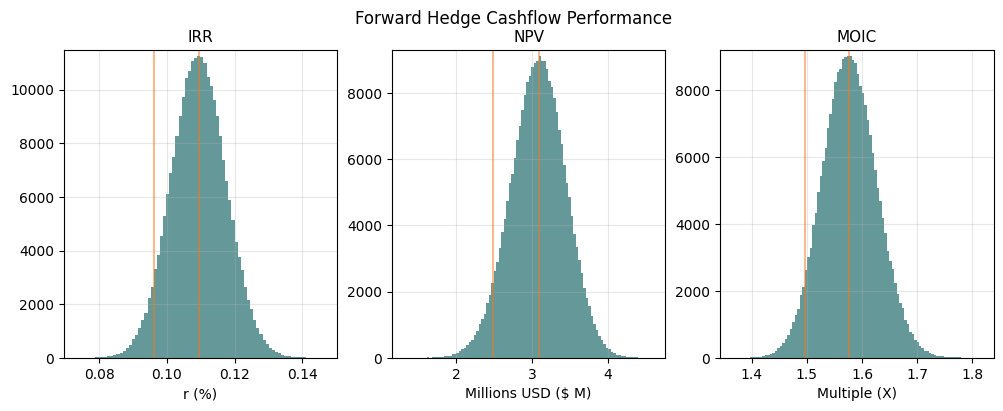

In [13]:
# Forward Hedge Results
fig = plt.figure(figsize = (12, 4))
plt.suptitle('Forward Hedge Cashflow Performance')

# IRR - Internal Rate of Return
ax = plt.subplot2grid((1, 3), (0, 0))

y, x, _ = ax.hist(
    x=performance_forward['irr'],
    bins=80,
    color=colors['c1']
)

# IRR VaR 95%
ax.vlines(
    x=risk_irr_forward['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Median
ax.vlines(
    x=risk_irr_forward['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Layout
ax.set_title('IRR', fontsize=11)
ax.set_xlabel('r (%)')
ax.set_ylim([0, y.max() * 1.02])
ax.grid(True, alpha=0.3)

# NPV - Net PResent Value
ax = plt.subplot2grid((1, 3), (0, 1))

y, x, _ = ax.hist(
    x=performance_forward['npv'],
    bins=100,
    color=colors['c1']
)

# NPV VaR 95%
ax.vlines(
    x=risk_npv_forward['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# NPV Median
ax.vlines(
    x=risk_npv_forward['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5,
)

# NPV Layout
ax.set_title('NPV', fontsize=11)
ax.set_xlabel('Millions USD ($ M)')
ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 4200])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}'))
#ax.set_xlim([-5*10**6, 0.0])
ax.grid(True, alpha=0.3)

# MOIC - Multiple on Invested Capital
ax = plt.subplot2grid((1, 3), (0, 2))

y, x, _ = ax.hist(
    x=performance_forward['moic'],
    bins=100,
    color=colors['c1'],
)

# MOIC VaR 95%
ax.vlines(
    x=risk_moic_forward['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Median
ax.vlines(
    x=risk_moic_forward['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Layout
ax.set_title('MOIC', fontsize=11)
ax.set_xlabel('Multiple (X)')
ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 5])
ax.grid(True, alpha=0.3)


## Put Options

In [14]:
s0_series = get_latest_quote(
    market_data=market_data,
    analysis_start_date=global_variables.analysis_start_date,
    ticker='spot',
    price='mid',
)
s0 = float(s0_series.iloc[0])

# Ask price to buy Option
vol1y_series = get_latest_quote(
    market_data=market_data,
    analysis_start_date=global_variables.analysis_start_date,
    ticker='1y_atm_vol',
    price='ask',
)
vol5y_series = get_latest_quote(
    market_data=market_data,
    analysis_start_date=global_variables.analysis_start_date,
    ticker='5y_atm_vol',
    price='ask',
)

vol_1y = float(vol1y_series.iloc[0])
vol_5y = float(vol5y_series.iloc[0])

print('s0 (spot_mid):', s0)
print('vol_1y (ask):', vol1y_series)
print('vol_5y (ask):', vol5y_series)


s0 (spot_mid): 1.15233
vol_1y (ask): 1y_atm_vol_ask    7.4
Name: 2025-08-01 00:00:00, dtype: float64
vol_5y (ask): 5y_atm_vol_ask    8.29
Name: 2025-08-01 00:00:00, dtype: float64


In [15]:
# Convert vol from % to decimal if needed
if vol_1y > 1.0:
    vol_1y /= 100.0
if vol_5y > 1.0:
    vol_5y /= 100.0

print("vol_1y (decimal):", vol_1y)
print("vol_5y (decimal):", vol_5y)

vol_1y (decimal): 0.07400000000000001
vol_5y (decimal): 0.08289999999999999


In [16]:
# Cashflows and their Dates 
cashflow_dates = np.asarray(cashflows.index)
cashflow_dates_idx = dates.get_indexer(cashflow_dates, method='pad')
cashflow_eur = np.asarray(cashflows['cf_eur'])

# Check Cashflow Dates Within Path Simulation Dates
if (cashflow_dates_idx < 0).any():
    missing = cashflow_dates[cashflow_dates_idx < 0]
    raise ValueError(f'Cashflow dates before simulation begins: {missing}')

In [17]:
path_dates = pd.DatetimeIndex(dates)
cashflow_dates = pd.DatetimeIndex(cashflow_dates)
cashflow_eur = np.asarray(cashflow_eur, dtype=float)

hedge_cashflows_usd_option, premium_option, strikes, vols_used = put_option_hedge_cashflows_usd(
    spot_paths=spot_paths,
    path_dates=path_dates,
    cashflow_dates=cashflow_dates,
    cashflow_eur=cashflow_eur,
    s0=s0,
    r_domestic=global_variables.r_domestic,
    r_foreign=global_variables.r_foreign,
    vol_1y=vol_1y,
    vol_5y=vol_5y,
    hedge_ratio=global_variables.hedging_ratio,
    start_date=global_variables.analysis_start_date,
)

print("hedge_cashflows_usd_option shape:", hedge_cashflows_usd_option.shape)
print("premium_option (USD):", premium_option)
print("strikes:", strikes)
print("vols_used:", vols_used)


hedge_cashflows_usd_option shape: (250000, 5)
premium_option (USD): 1022357.3070999851
strikes: [       nan 1.18732081 1.21814517 1.28230542 1.3155957 ]
vols_used: [       nan 0.07437185 0.07659685 0.08105295 0.0829    ]


In [18]:

cashflow_dates_idx = path_dates.get_indexer(cashflow_dates, method='pad')

# Expanded Cashflow Dates to Include premium payments upfront on analysis date
cashflow_dates_option = pd.DatetimeIndex(cashflow_dates).insert(0, global_variables.analysis_start_date)

# Prepering Perfromance Metrics
irr_option = np.empty(global_variables.n_paths, dtype=float)
moic_option = np.empty(global_variables.n_paths, dtype=float)
npv_option = np.empty(global_variables.n_paths, dtype=float)
terminal_option = np.empty(global_variables.n_paths, dtype=float)

for p in range(global_variables.n_paths):
    spots_on_cashflow_dates = spot_paths[p, cashflow_dates_idx]

    # Base + hedge USD cashflows at the loan cashflow dates (2025-10-01, ..., 2030-10-01)
    cashflow_usd_core = cashflow_eur * spots_on_cashflow_dates + hedge_cashflows_usd_option[p]

    cashflow_usd = np.concatenate([[-premium_option], cashflow_usd_core])

    irr_option[p] = irr(
        cashflow_dates=np.asarray(cashflow_dates_option),
        cashflows=cashflow_usd,
        start_date=cashflow_dates_option[0],
    )

    moic_option[p] = moic(cashflows=cashflow_usd)

    npv_option[p] = npv(
        cashflow_dates=np.asarray(cashflow_dates_option),
        cashflows=cashflow_usd,
        r=global_variables.discount_rate,
        start_date=global_variables.analysis_start_date,
    )

    terminal_option[p] = terminal_value(cashflows=cashflow_usd)

performance_option = {
    'strategy': 'option_put_atmf',
    'irr': irr_option,
    'moic': moic_option,
    'npv': npv_option,
    'terminal': terminal_option,
    'premium': premium_option,
    'strikes': strikes,
    'vols_used': vols_used,
}

nan_rate_irr_option = np.isnan(irr_option).mean()
print('IRR NaN rate :', nan_rate_irr_option)

IRR NaN rate : 0.0


In [19]:
risk_npv_option = risk_summary_for_metric(performance_option['npv'], alpha=0.95, loss='npv_shortfall')
risk_irr_option = risk_summary_for_metric(performance_option['irr'], alpha=0.95, loss='irr_shortfall')
risk_moic_option = risk_summary_for_metric(performance_option['moic'], alpha=0.95, loss='moic_shortfall')

p_npv_neg = prob_below(performance_option['npv'], 0.0)
p_irr_neg = prob_below(performance_option['irr'], 0.0)
p_moic_lt1 = prob_below(performance_option['moic'], 1.0)

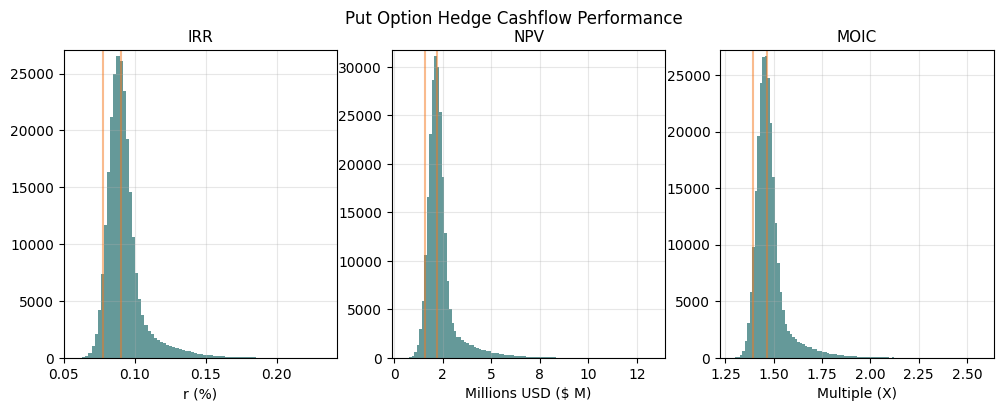

In [20]:
# Put Option Hedge Results
fig = plt.figure(figsize = (12, 4))
plt.suptitle('Put Option Hedge Cashflow Performance')

# IRR - Internal Rate of Return
ax = plt.subplot2grid((1, 3), (0, 0))

y, x, _ = ax.hist(
    x=performance_option['irr'],
    bins=80,
    color=colors['c1']
)

# IRR VaR 95%
ax.vlines(
    x=risk_irr_option['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Median
ax.vlines(
    x=risk_irr_option['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# IRR Layout
ax.set_title('IRR', fontsize=11)
ax.set_xlabel('r (%)')
ax.set_ylim([0, y.max() * 1.02])
ax.grid(True, alpha=0.3)

# NPV - Net PResent Value
ax = plt.subplot2grid((1, 3), (0, 1))

y, x, _ = ax.hist(
    x=performance_option['npv'],
    bins=100,
    color=colors['c1']
)

# NPV VaR 95%
ax.vlines(
    x=risk_npv_option['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# NPV Median
ax.vlines(
    x=risk_npv_option['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5,
)

# NPV Layout
ax.set_title('NPV', fontsize=11)
ax.set_xlabel('Millions USD ($ M)')
ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 4200])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}'))
#ax.set_xlim([-5*10**6, 0.0])
ax.grid(True, alpha=0.3)

# MOIC - Multiple on Invested Capital
ax = plt.subplot2grid((1, 3), (0, 2))

y, x, _ = ax.hist(
    x=performance_option['moic'],
    bins=100,
    color=colors['c1'],
)

# MOIC VaR 95%
ax.vlines(
    x=risk_moic_option['p05'],
    ymin=0,
    ymax=y.max() * 1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Median
ax.vlines(
    x=risk_moic_option['p50'],
    ymin=0,
    ymax=y.max()*1.3,
    color=colors['c2'],
    alpha=0.5
)

# MOIC Layout
ax.set_title('MOIC', fontsize=11)
ax.set_xlabel('Multiple (X)')
ax.set_ylim([0, y.max() * 1.02])
#ax.set_ylim([0, 5])
ax.grid(True, alpha=0.3)


### Comparing Results

In [ ]:
def build_strategy_risk_table(results: dict, alpha: float = 0.95) -> pd.DataFrame:
    '''
    Table in metric space + downside-risk (shortfall) VaR/ES in loss space.
    '''
    npv_sum  = risk_summary_for_metric(results['npv'],  alpha=alpha, loss='npv_shortfall')
    irr_sum  = risk_summary_for_metric(results['irr'],  alpha=alpha, loss='irr_shortfall')
    moic_sum = risk_summary_for_metric(results['moic'], alpha=alpha, loss='moic_shortfall')

    df = pd.DataFrame(
        {
            'NPV (USD)': npv_sum,
            'IRR (dec)': irr_sum,
            'MOIC (x)': moic_sum,
        }
    ).T

    cols = [
        'n', 'mean', 'std', 'p05', 'p50', 'p95',
        f'VaR{int(alpha*100)}_loss',
        f'ES{int(alpha*100)}_loss',
    ]
    return df[[c for c in cols if c in df.columns]]


def print_strategy_report(name: str, results: dict, alpha: float = 0.95) -> None:
    print('\n' + '=' * 90)
    print(f'STRATEGY: {name}')
    print('=' * 90)

    if 'premium' in results:
        print(f'Premium (USD): {float(results['premium']):,.2f}')
    if 'forwards' in results:
        fw = np.asarray(results['forwards'], float)
        fw = fw[np.isfinite(fw)]
        if fw.size:
            print(f'Forwards: min={fw.min():.6f}  max={fw.max():.6f}')
    if 'strikes' in results:
        k = np.asarray(results['strikes'], float)
        k = k[np.isfinite(k)]
        if k.size:
            print(f'Strikes (ATMF): min={k.min():.6f}  max={k.max():.6f}')
    if 'vols_used' in results:
        v = np.asarray(results['vols_used'], float)
        v = v[np.isfinite(v)]
        if v.size:
            print(f'Vols used: min={v.min():.4f}  max={v.max():.4f}')

    df = build_strategy_risk_table(results, alpha=alpha)
    print(df.to_string(float_format=lambda x: f'{x:,.6g}'))

    print('\nProbabilities (bad outcomes):')
    print(f"  P(NPV < 0)   = {prob_below(results['npv'], 0.0):.4%}")
    print(f"  P(IRR < 0)   = {prob_below(results['irr'], 0.0):.4%}")
    print(f"  P(MOIC < 1)  = {prob_below(results['moic'], 1.0):.4%}")


In [22]:
alpha = 0.95

print_strategy_report("UNHEDGED", performance_unhedged, alpha=alpha)


STRATEGY: UNHEDGED
Premium (USD): 0.00
                n        mean         std          p05         p50        p95  VaR95_loss   ES95_loss
NPV (USD) 250,000 1.48179e+06 1.96399e+06 -1.45139e+06 1.32267e+06 4.9493e+06 1.45139e+06  2.0339e+06
IRR (dec) 250,000    0.077615   0.0374343    0.0172579   0.0769908   0.140133           0 0.000205338
MOIC (x)  250,000     1.39964    0.216463       1.0768     1.38222    1.78195           0 0.000847941

Probabilities (bad outcomes):
  P(NPV < 0)   = 23.2368%
  P(IRR < 0)   = 1.6212%
  P(MOIC < 1)  = 1.6212%


In [23]:
print_strategy_report("FORWARD HEDGED", performance_forward, alpha=alpha)



STRATEGY: FORWARD HEDGED
Premium (USD): 0.00
Forwards: min=1.157276  max=1.315596
                n        mean        std         p05         p50         p95  VaR95_loss  ES95_loss
NPV (USD) 250,000 3.07918e+06    359,156 2.47919e+06 3.08536e+06 3.65958e+06           0          0
IRR (dec) 250,000    0.109386 0.00810604   0.0961281    0.109356    0.122779           0          0
MOIC (x)  250,000     1.57742  0.0495568     1.49727     1.57671     1.66016           0          0

Probabilities (bad outcomes):
  P(NPV < 0)   = 0.0000%
  P(IRR < 0)   = 0.0000%
  P(MOIC < 1)  = 0.0000%


In [24]:
print_strategy_report("OPTION HEDGED (ATMF PUT)", performance_option, alpha=alpha)


STRATEGY: OPTION HEDGED (ATMF PUT)
Premium (USD): 1,022,357.31
Strikes (ATMF): min=1.187321  max=1.315596
Vols used: min=0.0744  max=0.0829
                n        mean       std         p05         p50         p95  VaR95_loss  ES95_loss
NPV (USD) 250,000 2.36554e+06   809,132 1.56717e+06 2.20029e+06 3.95809e+06           0          0
IRR (dec) 250,000   0.0924503 0.0131497    0.077682   0.0900707    0.118132           0          0
MOIC (x)  250,000     1.47918 0.0836514     1.39164     1.46285     1.63992           0          0

Probabilities (bad outcomes):
  P(NPV < 0)   = 0.0000%
  P(IRR < 0)   = 0.0000%
  P(MOIC < 1)  = 0.0000%


In [25]:
cashflows

,cf_eur
date,
2025-10-01,-10000000.0
2026-10-01,1000000.0
2027-10-01,1000000.0
2029-10-01,1000000.0
2030-10-01,11000000.0


In [26]:
hedge_cashflows_usd_option

array([[      0.        ,  228693.38787501,  252554.81252737,
         181867.62132445,  859809.86525088],
       [      0.        ,   28802.15322908,   71641.88441459,
         289633.68441506, 2631984.43687052],
       [      0.        ,  106584.24013257,  190369.68838741,
         176298.79646891, 1418501.51744846],
       ...,
       [      0.        ,       0.        ,   12562.0967489 ,
              0.        ,       0.        ],
       [      0.        ,  132235.29299779,  166897.54206411,
         126026.29537193, 1782665.45800694],
       [      0.        ,       0.        ,   63023.87619261,
         130937.62073912, 2738221.65329811]], shape=(250000, 5))